# TabNet Regressor Tutorial 

- source: https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example

## Basic Packages

In [1]:
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
!jupyter lab --version

4.1.3


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-24449304-a305-dbe0-a5c8-bc765274bece)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-1761614d-0d31-5a98-6d73-e9cabf8b877a)


## Read, Explore and Load Data

#### Read Data

In [6]:
!pwd

/app/tabnet/tutorial/tabnet-regressor


In [7]:
!ls /app/tabnet/tutorial/tabnet-regressor/data

data_description.txt  sample_submission.csv  solution.csv  test.csv  train.csv


In [8]:
datadir = '/app/tabnet/tutorial/tabnet-regressor/data/'

In [9]:
%%time
traindf = pd.read_csv(datadir+'train.csv')
testdf  = pd.read_csv(datadir+'test.csv')

CPU times: user 14.5 ms, sys: 13.1 ms, total: 27.6 ms
Wall time: 27.1 ms


In [10]:
soldf = pd.read_csv(datadir+'solution.csv')

In [11]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [13]:
soldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [14]:
testdf[['Id','SaleType','SaleCondition']].head()

,Id,SaleType,SaleCondition
0,1461,WD,Normal
1,1462,WD,Normal
2,1463,WD,Normal
3,1464,WD,Normal
4,1465,WD,Normal


In [15]:
soldf.head()

,Id,SalePrice
0,1461,105000.0
1,1462,172000.0
2,1463,189900.0
3,1464,195500.0
4,1465,191500.0


In [16]:
traindf[['Id','SaleType','SaleCondition','SalePrice']].head()

,Id,SaleType,SaleCondition,SalePrice
0,1,WD,Normal,208500
1,2,WD,Normal,181500
2,3,WD,Normal,223500
3,4,WD,Abnorml,140000
4,5,WD,Normal,250000


#### Input Features

In [17]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
            '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',  'Fireplaces', 
            'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch',  'PoolArea', 'YrSold']

#### Data Prep.

In [18]:
X      = traindf[features].astype('float64')
y      = np.log1p(traindf["SalePrice"].astype('float64'))
X_test = testdf[features].astype('float64')
y_true = soldf["SalePrice"].astype('float64')

In [19]:
# Impute Data using mean (or median)
X      =      X.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   float64
 1   OverallQual    1460 non-null   float64
 2   OverallCond    1460 non-null   float64
 3   YearBuilt      1460 non-null   float64
 4   YearRemodAdd   1460 non-null   float64
 5   BsmtFinSF1     1460 non-null   float64
 6   BsmtFinSF2     1460 non-null   float64
 7   TotalBsmtSF    1460 non-null   float64
 8   1stFlrSF       1460 non-null   float64
 9   LowQualFinSF   1460 non-null   float64
 10  GrLivArea      1460 non-null   float64
 11  BsmtFullBath   1460 non-null   float64
 12  BsmtHalfBath   1460 non-null   float64
 13  HalfBath       1460 non-null   float64
 14  BedroomAbvGr   1460 non-null   float64
 15  Fireplaces     1460 non-null   float64
 16  GarageCars     1460 non-null   float64
 17  GarageArea     1460 non-null   float64
 18  WoodDeck

In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1459 non-null   float64
 1   OverallQual    1459 non-null   float64
 2   OverallCond    1459 non-null   float64
 3   YearBuilt      1459 non-null   float64
 4   YearRemodAdd   1459 non-null   float64
 5   BsmtFinSF1     1459 non-null   float64
 6   BsmtFinSF2     1459 non-null   float64
 7   TotalBsmtSF    1459 non-null   float64
 8   1stFlrSF       1459 non-null   float64
 9   LowQualFinSF   1459 non-null   float64
 10  GrLivArea      1459 non-null   float64
 11  BsmtFullBath   1459 non-null   float64
 12  BsmtHalfBath   1459 non-null   float64
 13  HalfBath       1459 non-null   float64
 14  BedroomAbvGr   1459 non-null   float64
 15  Fireplaces     1459 non-null   float64
 16  GarageCars     1459 non-null   float64
 17  GarageArea     1459 non-null   float64
 18  WoodDeck

In [22]:
X.head().T

,0,1,2,3,4
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0
OverallQual,7.0,6.0,7.0,7.0,8.0
OverallCond,5.0,8.0,5.0,5.0,5.0
YearBuilt,2003.0,1976.0,2001.0,1915.0,2000.0
YearRemodAdd,2003.0,1976.0,2002.0,1970.0,2000.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0
BsmtFinSF2,0.0,0.0,0.0,0.0,0.0
TotalBsmtSF,856.0,1262.0,920.0,756.0,1145.0
1stFlrSF,856.0,1262.0,920.0,961.0,1145.0
LowQualFinSF,0.0,0.0,0.0,0.0,0.0


In [23]:
X_test.head().T

,0,1,2,3,4
LotArea,11622.0,14267.0,13830.0,9978.0,5005.0
OverallQual,5.0,6.0,5.0,6.0,8.0
OverallCond,6.0,6.0,5.0,6.0,5.0
YearBuilt,1961.0,1958.0,1997.0,1998.0,1992.0
YearRemodAdd,1961.0,1958.0,1998.0,1998.0,1992.0
BsmtFinSF1,468.0,923.0,791.0,602.0,263.0
BsmtFinSF2,144.0,0.0,0.0,0.0,0.0
TotalBsmtSF,882.0,1329.0,928.0,926.0,1280.0
1stFlrSF,896.0,1329.0,928.0,926.0,1280.0
LowQualFinSF,0.0,0.0,0.0,0.0,0.0


In [24]:
X      = X.to_numpy()
y      = y.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

## Training ... 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
%%time 

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TabNet Regressor
regressor = TabNetRegressor(verbose=0, seed=42)

# Train the model
regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    patience=300, max_epochs=2000,
    eval_metric=['rmse']
)

# Make predictions on the test set
predictions = np.expm1(regressor.predict(X_test))

# Get feature importances
feature_importances = regressor.feature_importances_

#print("Predictions:", predictions)
print("Feature Importances:", feature_importances)


Early stopping occurred at epoch 1568 with best_epoch = 1268 and best_val_0_rmse = 0.16956
Predictions: [[118224.305]
 [173139.58 ]
 [182354.66 ]
 ...
 [183135.25 ]
 [115018.16 ]
 [231690.67 ]]
Feature Importances: [0.02325032 0.09303239 0.01491401 0.00087647 0.07875267 0.00024108
 0.00258202 0.08203063 0.0323725  0.00537438 0.11822671 0.09817583
 0.0025097  0.17743667 0.         0.01771392 0.03415022 0.0165148
 0.04305575 0.05201619 0.07178136 0.00439641 0.03059597]
CPU times: user 50 s, sys: 276 ms, total: 50.3 s
Wall time: 50.3 s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Results 

#### Performance Metrics

In [31]:
len(y_true), len(predictions)

(1459, 1459)

In [32]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The LB score is %.5f" % RMSLE )

The LB score is 0.16664


#### Average Feature Importance

In [34]:
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Print or visualize the feature importance
print(importance_df)

          Feature  Importance
14   BedroomAbvGr    0.000000
5      BsmtFinSF1    0.000241
3       YearBuilt    0.000876
12   BsmtHalfBath    0.002510
6      BsmtFinSF2    0.002582
21       PoolArea    0.004396
9    LowQualFinSF    0.005374
2     OverallCond    0.014914
17     GarageArea    0.016515
15     Fireplaces    0.017714
0         LotArea    0.023250
22         YrSold    0.030596
8        1stFlrSF    0.032373
16     GarageCars    0.034150
18     WoodDeckSF    0.043056
19    OpenPorchSF    0.052016
20  EnclosedPorch    0.071781
4    YearRemodAdd    0.078753
7     TotalBsmtSF    0.082031
1     OverallQual    0.093032
11   BsmtFullBath    0.098176
10      GrLivArea    0.118227
13       HalfBath    0.177437


## Visualize the predictions 

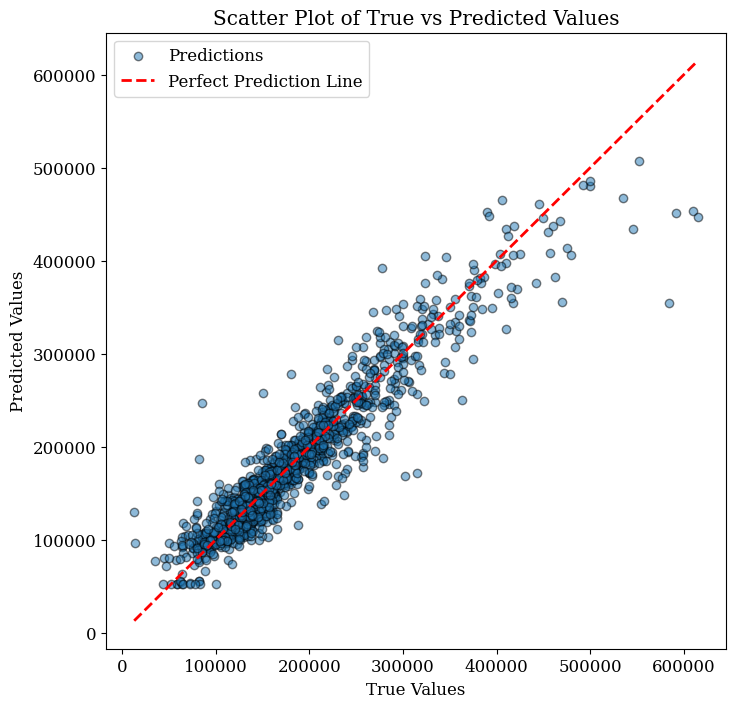

In [35]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 12})
plt.rcParams['mathtext.fontset'] = 'stix'

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, predictions, alpha=0.5, edgecolors='k', label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', \
         lw=2, label='Perfect Prediction Line')

# Add titles and labels
plt.title('Scatter Plot of True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show plot
plt.show()


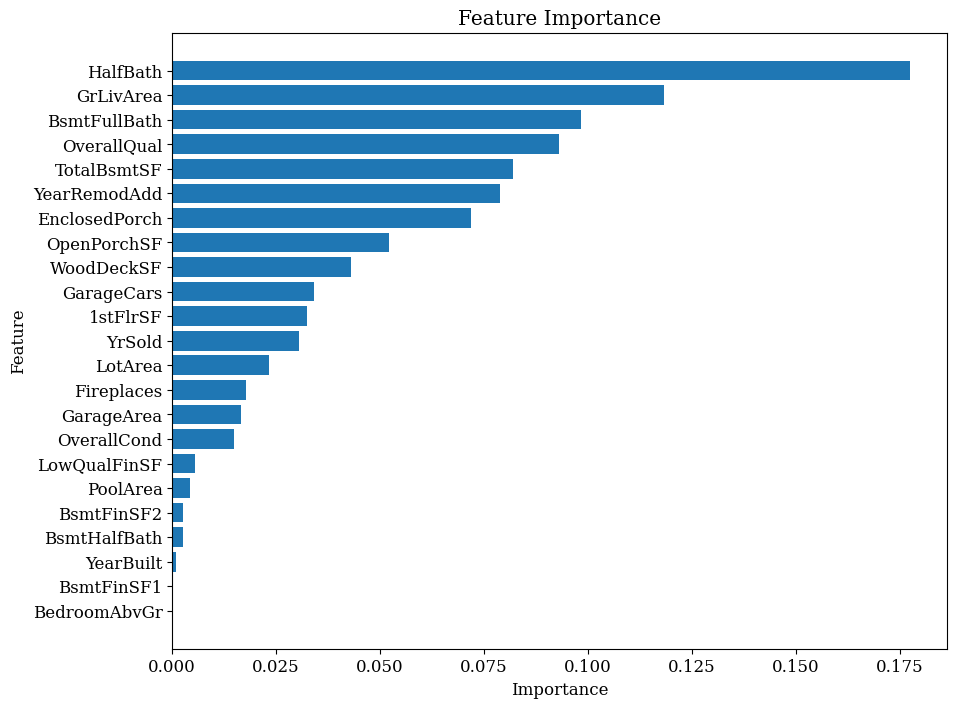

In [36]:
# Visualize the feature importance (example with matplotlib)
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 12})
plt.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()